In [3]:
import numpy as np
import databento as db
import matplotlib.pyplot as plt
import pandas as pd

def fetch_data(dataset,symbols,start,end,schema=None): #### read data from databento
    client = db.Historical("db-GW8s9wBDJVfBDbUcdKJWFFGCwjxAF")
    data = client.timeseries.get_range(
        dataset=dataset,
        symbols=symbols,
        schema=schema,
        start = start,
        end = end
    )
    return data

def describe_df(df,plot_cols): ### description / summary
    symbols = list(df["symbol"].drop_duplicates().to_numpy())
    df = df[plot_cols+["symbol"]]
    for symbol in symbols:
        symb_df = df.loc[df["symbol"] == symbol]
        for col in plot_cols:
            plt.figure(figsize=(6,4))
            symb_df[col].plot(title = f"{col},{symbol}")
            plt.grid()
            plt.show()
    return df.groupby("symbol").describe(include = 'all')


def df_aggreg(df,resample, agg_dict): ### Some aggregation for any column list
    symbols = df["symbol"].drop_duplicates().to_numpy()
    aggreg_df = []
    for symbol in symbols:
        symb_df = df.loc[df["symbol"] == symbol]
        symb_df = symb_df[agg_dict.keys()].resample(resample).agg(agg_dict)
        symb_df["symbol"] = symbol 
        aggreg_df.append(symb_df)
    aggreg_df = pd.concat(aggreg_df)
    return aggreg_df

def liquidity_metrics(df,level): ### does VWAP, BBO, depth
    pattern = r'_0[' + '0-' + str(level) + r']$' 
    filtered_df = df.filter(regex=pattern)
    filtered_df = filtered_df.copy()
    filtered_df["symbol"] = df["symbol"]
    filtered_df["ts_delta"] = df["ts_in_delta"]
    VWP = np.zeros(len(filtered_df))
    tot_vols = np.zeros(len(filtered_df))
    for i in range(level):
        level_req = '0' + str(i)
        bid_col = "bid_q_" + level_req
        ask_col = "ask_q_" + level_req
        filtered_df.loc[:,bid_col] = filtered_df["bid_sz_" + level_req] * filtered_df["bid_ct_" + level_req]
        filtered_df.loc[:,ask_col] = filtered_df["ask_sz_" + level_req] * filtered_df["ask_ct_" + level_req]
        VWP += (filtered_df["bid_px_" + level_req]*filtered_df[bid_col] + filtered_df["ask_px_" + level_req]*filtered_df[ask_col]).to_numpy()
        tot_vols += filtered_df[bid_col].to_numpy() + filtered_df[ask_col].to_numpy()
    VWAP = VWP/tot_vols
    filtered_df["VWAP"] = VWAP
    filtered_df["depth"] = tot_vols
    filtered_df["BBO_spread"] = filtered_df["ask_px_00"] - filtered_df["bid_px_00"]
    return filtered_df

In [2]:
pd.options.display.float_format = '{:,.4f}'.format

In [6]:
start="2024-07-17T13:30:00" ### UTC time
end="2024-07-17T20:00:00"
dataset = "XNAS.ITCH"
symbols = ["NVDA", "MED"]
#MBO_data = fetch_data(dataset, symbols, start, end, schema = "MBO").to_df()
MBP_data = fetch_data(dataset, symbols, start, end, schema = "MBP-10").to_csv("stock_order.csv")
ohlc_data = fetch_data(dataset, symbols, start, end, schema = "ohlcv-1s").to_csv("ohlc.csv")
trade_data = fetch_data(dataset, symbols, start, end, schema = "trades").to_csv("stock_trade.csv")

In [10]:
data = pd.read_csv("stock_order.csv")

In [15]:
columns_to_remove = data.filter(regex=r'name_0[4-9]$').columns
# Remove columns whose names are in the range 04-09
data = data.drop(columns=columns_to_remove)

In [16]:
data.to_csv("stock_order.csv")

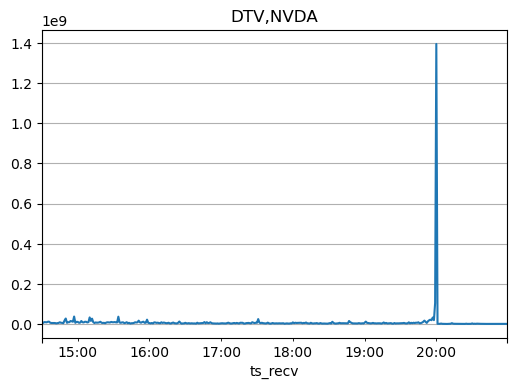

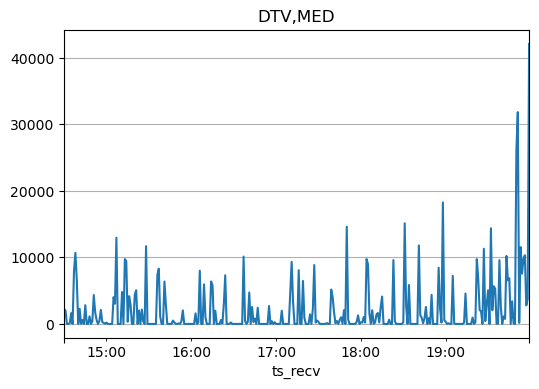

CPU times: total: 547 ms
Wall time: 1.7 s


DTV                                                                 \
        count          mean           std       min          25%         50%   
symbol                                                                         
MED     330.0  2.101092e+03  4.478197e+03      0.00        0.000      102.55   
NVDA    390.0  8.892927e+06  7.077782e+07  10806.62  2397154.245  3806235.31   

                                    
                 75%           max  
symbol                              
MED     2.150557e+03  4.210962e+04  
NVDA    6.080095e+06  1.396005e+09

In [5]:
%%time
trade_data["DTV"] = trade_data["price"]*trade_data["size"] ### Dollar traded volume
agg_dict = {"DTV" : "sum", "size" : "sum"}
aggreg_req = df_aggreg(trade_data, "min", agg_dict)
#trade_size = df_aggreg(trade_data, "min", "size")
describe_df(aggreg_req,["DTV"])

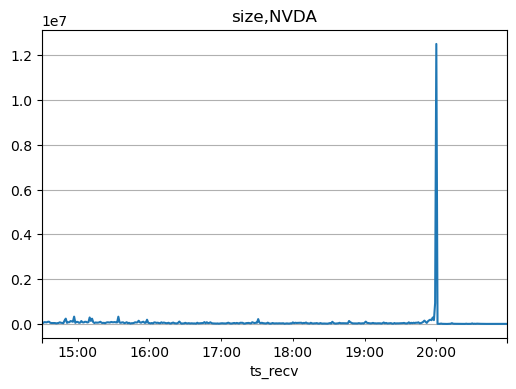

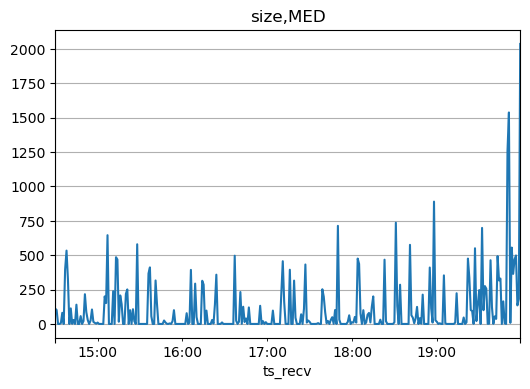

CPU times: total: 422 ms
Wall time: 522 ms


size                                                           \
        count      mean        std   min       25%       50%       75%   
symbol                                                                   
MED    330.00    102.52     217.44  0.00      0.00      5.00    106.50   
NVDA   390.00 79,302.68 634,267.28 97.00 21,286.75 33,433.50 54,192.00   

                      
                 max  
symbol                
MED         2,035.00  
NVDA   12,510,184.00

In [12]:
%%time
describe_df(aggreg_req,["size"])

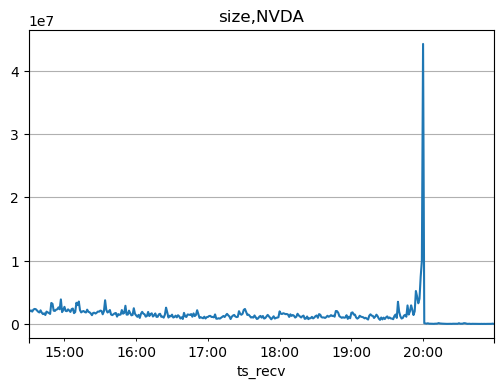

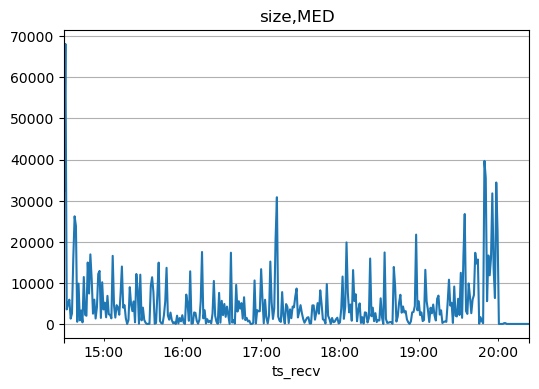

CPU times: total: 1.86 s
Wall time: 2.13 s


size                                                             \
        count         mean          std      min        25%          50%   
symbol                                                                     
MED    355.00     4,805.02     7,216.39     0.00     512.50     2,226.00   
NVDA   390.00 1,442,547.06 2,372,956.09 5,430.00 953,526.50 1,255,013.00   

                                   
                75%           max  
symbol                             
MED        5,599.00     68,119.00  
NVDA   1,699,979.75 44,260,633.00

In [13]:
%%time
Total_orders = df_aggreg(MBO_data, "min", {"size" : "sum"})
describe_df(Total_orders,["size"])

In [14]:
%%time
ohlc_aggreg = df_aggreg(ohlc_data, "min", {"open" : "mean", "high" : "mean", "low" : "mean", "close" : "mean"}) ### do something about printing / describing this

CPU times: total: 0 ns
Wall time: 12.5 ms


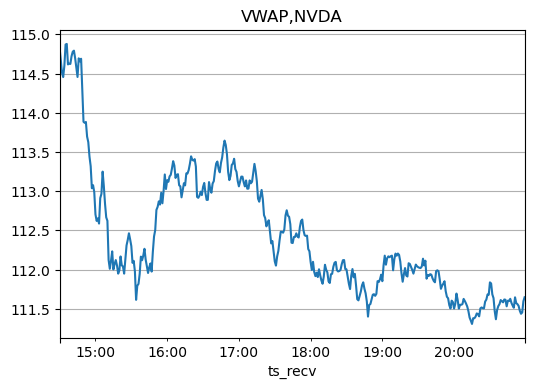

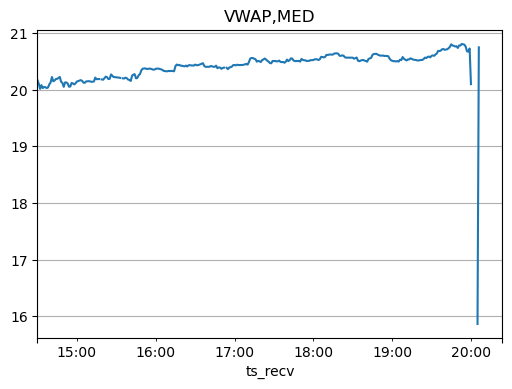

CPU times: total: 1.95 s
Wall time: 2.04 s


VWAP                                                             
          count     mean    std      min      25%      50%      75%      max
symbol                                                                      
MED    331.0000  20.4241 0.3111  15.8666  20.3309  20.4926  20.5562  20.8104
NVDA   390.0000 112.4246 0.8063 111.3081 111.8476 112.1269 113.0260 114.8790

In [75]:
%%time
liquidity_summary = liquidity_metrics(MBP_data,3)
agg_dict = {"VWAP" : "mean", "BBO_spread" : "mean"}
liquidity_aggreg = df_aggreg(liquidity_summary, "min", agg_dict)
describe_df(liquidity_aggreg, ["VWAP"])

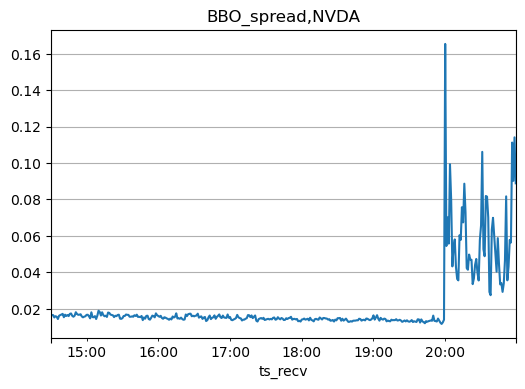

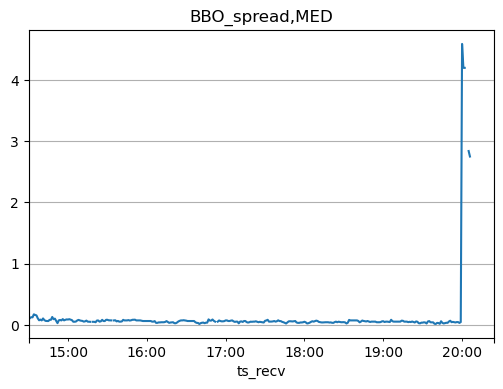

BBO_spread                                                 
            count   mean    std    min    25%    50%    75%    max
symbol                                                            
MED      333.0000 0.1175 0.4787 0.0122 0.0400 0.0514 0.0678 4.5910
NVDA     390.0000 0.0216 0.0188 0.0116 0.0140 0.0150 0.0165 0.1654

In [74]:
describe_df(liquidity_aggreg, ["BBO_spread"])

In [76]:
trade_data

,ts_event,rtype,publisher_id,instrument_id,action,side,depth,price,size,flags,ts_in_delta,sequence,symbol,DTV
ts_recv,,,,,,,,,,,,,,
2024-07-29 14:30:00.015779953+00:00,2024-07-29 14:30:00.015610911+00:00,0,2,11667,T,A,0,114.9400,88,130,169042,166794261,NVDA,"10,114.7200"
2024-07-29 14:30:00.015807343+00:00,2024-07-29 14:30:00.015639378+00:00,0,2,11667,T,A,0,114.9400,12,128,167965,166794267,NVDA,"1,379.2800"
2024-07-29 14:30:00.211391316+00:00,2024-07-29 14:30:00.211221589+00:00,0,2,11667,T,B,0,114.9500,59,128,169727,166812689,NVDA,"6,782.0500"
2024-07-29 14:30:00.211670174+00:00,2024-07-29 14:30:00.211501887+00:00,0,2,11667,T,A,0,114.9500,20,0,168287,166812825,NVDA,"2,299.0000"
2024-07-29 14:30:00.211670174+00:00,2024-07-29 14:30:00.211501887+00:00,0,2,11667,T,A,0,114.9500,7,128,168287,166812826,NVDA,804.6500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-29 20:59:37.246109113+00:00,2024-07-29 20:59:37.245943060+00:00,0,2,11667,T,B,0,111.6000,12,130,166053,632355050,NVDA,"1,339.2000"
2024-07-29 20:59:39.940757201+00:00,2024-07-29 20:59:39.940590912+00:00,0,2,11667,T,A,0,111.6000,100,130,166289,632355785,NVDA,"11,160.0000"
2024-07-29 20:59:41.014318988+00:00,2024-07-29 20:59:41.014152222+00:00,0,2,11667,T,B,0,111.6000,4,130,166766,632356306,NVDA,446.4000
